In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

#fileloc = '/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-4.7.0/20180303/lz_201803030000_lzap.root'
fileloc = glob.glob('/global/cfs/cdirs/lz/data/MDC3/background/LZAP-4.7.0/20180426/*.root*')
#fileloc = glob.glob('/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-dev-ffn-951eb859/20180303/*.root*') #Kr injection
#/global/cfs/cdirs/lz/data/MDC3/commissioning/BACCARAT-4.10.3_DER-8.5.13/20180303/ #Kr DER path
#fileloc = glob.glob('/global/cfs/cdirs/lz/data/MDC3/calibration/LZAP-dev-ffn-951eb859/20180312/*.root*') #Rn data
#fileloc = glob.glob('/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-4.7.0/20180303/*.root*')
#thefile = '/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-4.7.0/20180303/lz_201803030922_lzap.root'
#thefile = '/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-4.7.0/20180303/lz_201803030001_lzap.root'

SS EVENTS

In [5]:
def singlescatters(thefile):    
    #get the pulse IDs for s1 and s2 in single scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventID = events.array('eventHeader.eventID')
    sscatterS1 = scatters.array('ss.s1PulseID')
    sscatterS2 = scatters.array('ss.s2PulseID')
    nss = scatters.array('ss.nSingleScatters')
    s1c = scatters.array('ss.s1Area_phd')
    s2c = scatters.array('ss.s2Area_phd')
    zc = scatters.array('ss.correctedZ_cm')
    xc = scatters.array('ss.x_cm')
    yc = scatters.array('ss.y_cm')
    rc = np.sqrt(xc ** 2 + yc ** 2)
    sda = scatters.array('ss.skinDomeArea')
    sba = scatters.array('ss.skinBarrelArea')
    od = scatters.array('ss.odPromptArea')
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    drift = scatters.array('ss.driftTime_ns') / 1000
    
    goodID = ~np.isnan(s2c) #get all events without nan
    
    upperz = drift < 788.629 
    lowerz = drift > 72.414
    FIDZ_ID = np.logical_and(upperz,lowerz) #fidz cut

    FIDR_ID = [] #fidR cut
    for i, r in enumerate(rc):
        if r < 68.8:
            FIDR_ID.append(i)
        else:
            FIDR_ID.append(False)
            
    #Skin cut
    #skindome = sda <= 5
    #skinbarrel = sba <= 5
    #skinID = np.logical_and(skindome,skinbarrel)
    
    #OD cut
    #odID = od <= 10

    Emin = s1c > 100
    Emax = s1c < 500
    EFTID = np.logical_and(Emin,Emax)# EFT cut 
    
    #s2 area cut
    s2min = s2c > 420
    s2max = s2c < 10**8
    s2ID = np.logical_and(s2min,s2max)
    
    ID = np.logical_and.reduce([goodID,FIDZ_ID,FIDR_ID,EFTID,s2ID]) #make a boolean mask of all the cuts

    s2c = s2c[ID] #apply it to get only the events we want
    s1c = s1c[ID]
    sscatterS1 = sscatterS1[ID]
    sscatterS2 = sscatterS2[ID]
    eventID = eventID[ID]
    rawfile = rawfile[ID]
    runID = runID[ID]
    startTime_us = startTime_us[ID]
    
    if s2c.size > 0:
        sstext = open("/global/project/projectdirs/lz/users/mwilliams/SS500phd_fortruth.txt", "a+")
        sstext2 = open("/global/project/projectdirs/lz/users/mwilliams/SS500phd_fortruthGuide.txt", "a+")
        for (i,j,k) in zip(rawfile,runID,eventID):
            i = i.decode('utf-8')
            sstext.write("/global/cfs/cdirs/lz/data/MDC3/background/BACCARAT-4.11.0_DER-8.5.13/20180426/%s" " " "%s" " " "%s" "\n" % (i,j,k))
        sstext.close()
        for (a,b,c,d,e) in zip(rawfile,runID,eventID,startTime_us,sscatterS1):
            a = a.decode('utf-8')
            sstext2.write("/global/cfs/cdirs/lz/data/MDC3/background/BACCARAT-4.11.0_DER-8.5.13/20180426/%s" " " "%s" " " "%s" " " "%s" " " "%s" "\n" % (a,b,c,d,e))
        sstext2.close()
    else: 
        pass

    return ID, sscatterS1, sscatterS2, s1c, s2c,eventID #we return the mask for use in the ratio plots later

In [6]:
EID = []  #make arrays to load function results into
ssS1PID = []
ssS2PID = []
ssS1area = []
ssS2area = []

In [7]:
nfiles = len(fileloc) # run the function over the list of files
for i, file in enumerate(fileloc):
    if file == "/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-dev-ffn-951eb859/20180303/lz_201803032300_lzap.root":
            continue
    sscatterS1, sscatterS2, s1c, s2c,eventID = singlescatters(file)[1:6] #we don't care about having the mask returned here
    ssS1PID.append(sscatterS1)
    ssS2PID.append(sscatterS2)
    ssS1area.append(s1c)
    ssS2area.append(s2c)
    EID.append(eventID)
    update_progress(i, nfiles)

N Files to process = 142 
Progress: [####################] 99.3%


In [ ]:
#ssS1PID = list(itertools.chain.from_iterable(ssS1PID)) #flatten this list
#ssS2PID = list(itertools.chain.from_iterable(ssS2PID))
print(len(ssS2PID))

In [44]:
ssS1area = list(itertools.chain.from_iterable(ssS1area)) #flatten these too
ssS2area = list(itertools.chain.from_iterable(ssS2area))
print(len(ssS2area))

318755


In [ ]:
logs1 = np.log10(ssS1area) #take logs of areas
logs2 = np.log10(ssS2area)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(logs1, logs2, bins=(1000, 1000),range =  [[0,3], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('SS S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.show()

MS EVENTS

In [2]:
def multiscatters(thefile):     
    #get the pulse IDs for s1 and s2 in multiple scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventID = events.array('eventHeader.eventID')
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    mscatterS1 = scatters.array('ms.s1PulseID')
    mscatterS2 = scatters.array('ms.s2PulseIDs')
    nms = scatters.array('ms.nMultipleScatters')
    ms_s1c = scatters.array('ms.s1Area_phd')
    ms_s2c = scatters.array('ms.s2Area_phd')
    ms_xc = scatters.array('ms.x_cm')
    ms_yc = scatters.array('ms.y_cm')
    ms_rc = np.sqrt(ms_xc ** 2 + ms_yc ** 2)
    sda = scatters.array('ms.skinDomeArea')
    sba = scatters.array('ms.skinBarrelArea')
    od = scatters.array('ms.odPromptArea')
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    drift = scatters.array('ms.driftTime_ns') / 1000


    ms_goodID = ms_s2c.max() > 0 #get ms
    ms_s2c = ms_s2c[ms_goodID]
    drift = drift[ms_goodID]
    ms_rc = ms_rc[ms_goodID]
    ms_s1c = ms_s1c[ms_goodID]
    sba = sba[ms_goodID]
    sda = sda[ms_goodID]
    od = od[ms_goodID]
    eventID = eventID[ms_goodID]
    runID = runID[ms_goodID]
    rawfile = rawfile[ms_goodID]
    startTime_us = startTime_us[ms_goodID]
    mscatterS2 = mscatterS2[ms_goodID]

    maxID = ms_s2c.argsort() == 0 #this is to get the largest s2
    ms_s2c = ms_s2c[maxID]
    ms_rc = ms_rc[maxID]
    drift = drift[maxID]
    mscatterS2 = mscatterS2[maxID]
    startTime_us = startTime_us[mscatterS2]
    ms_s2c = ms_s2c.flatten()
    ms_rc = ms_rc.flatten()
    drift = drift.flatten()
    startTime_us = startTime_us.flatten()
    mscatterS2 = mscatterS2.flatten()

    upperz = drift < 788.629 
    lowerz = drift > 72.414
    fidz = np.logical_and(upperz,lowerz) #fidz cut


    MSFIDR_ID = []
    for i, r in enumerate(ms_rc):
        if r < 68.8:
            MSFIDR_ID.append(True)
        else:
            MSFIDR_ID.append(False)


    #skindome = sda <= 5
    #skinbarrel = sba <= 5
    #MSskinID = np.logical_and(skindome,skinbarrel)


    #MSodID = od <= 10


    s2min = ms_s2c > 420
    s2max = ms_s2c < 10**8
    MSs2ID = np.logical_and(s2min,s2max)


    Emin = ms_s1c > 100
    Emax = ms_s1c < 500
    MSEFTID = np.logical_and(Emin,Emax)# EFT cut

    MS_ID = np.logical_and.reduce([fidz,MSFIDR_ID,MSEFTID,MSs2ID])
    ms_s2c = ms_s2c[MS_ID]
    ms_s1c = ms_s1c[MS_ID]
    eventID = eventID[MS_ID]
    runID = runID[MS_ID]
    rawfile = rawfile[MS_ID]
    mscatterS2 = mscatterS2[MS_ID]
    startTime_us = startTime_us[MS_ID]
    
    if ms_s2c.size > 0:
        mstext = open("/global/project/projectdirs/lz/users/mwilliams/MS500phd_fortruth.txt", "a+")
        mstext2 = open("/global/project/projectdirs/lz/users/mwilliams/MS500phd_fortruthGuide.txt", "a+")
        for (i,j,k) in zip(rawfile,runID,eventID):
            i = i.decode('utf-8')
            mstext.write("/global/cfs/cdirs/lz/data/MDC3/background/BACCARAT-4.11.0_DER-8.5.13/20180426/%s" " " "%s" " " "%s" "\n" % (i,j,k))
        mstext.close()
        for (a,b,c,d,e) in zip(rawfile,runID,eventID,startTime_us,mscatterS1):
            a = a.decode('utf-8')
            mstext2.write("/global/cfs/cdirs/lz/data/MDC3/background/BACCARAT-4.11.0_DER-8.5.13/20180426/%s" " " "%s" " " "%s" " " "%s" " " "%s" "\n" % (a,b,c,d,e))
        mstext2.close()
    else: 
        pass
    return MS_ID, mscatterS1, mscatterS2, ms_s1c, ms_s2c,eventID

In [3]:
msEID = []
msS1PID = []
msS2PID = []
msS1area = []
msS2area = []

In [4]:
nfiles = len(fileloc)
for i, file in enumerate(fileloc):
    mscatterS1, mscaterS2, ms_s1c, ms_s2c,eventID = multiscatters(file)[1:6]
    msS1PID.append(mscatterS1)
    msS2PID.append(mscaterS2)
    msS1area.append(ms_s1c)
    msS2area.append(ms_s2c)
    msEID.append(eventID)
    update_progress(i, nfiles)

N Files to process = 142 
Progress: [####################] 99.3%


In [48]:
msS1PID = list(itertools.chain.from_iterable(msS1PID))
msS2PID = list(itertools.chain.from_iterable(msS2PID))
#msS1PID = list(itertools.chain.from_iterable(msS1PID))
#msS2PID = list(itertools.chain.from_iterable(msS2PID))
print(len(msS2PID))

35


In [14]:
print(len(msEID))

1440


In [16]:
#msS1area = list(itertools.chain.from_iterable(msS1area))
#msS2area = list(itertools.chain.from_iterable(msS2area))
#msS1area = list(itertools.chain.from_iterable(msS1area))
#msS2area = list(itertools.chain.from_iterable(msS2area))
print(len(msS1area))

284


In [53]:
mslogs1 = np.log10(msS1area)
mslogs2 = np.log10(msS2area)

In [54]:
print(len(mslogs1))
print(len(mslogs2))

254
254


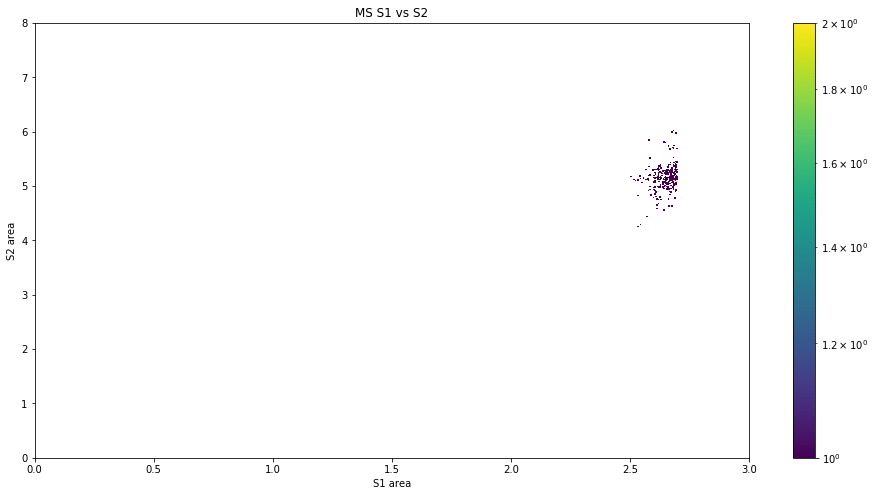

In [55]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(mslogs1, mslogs2, bins=(1000, 1000),range = [[0,3], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('MS S1 vs S2')
ax.set_xlabel('S1 area')
ax.set_ylabel('S2 area')
plt.show()

KR83 EVENTS

In [ ]:
def krscatters(thefile):    
    #get the pulse IDs for s1 and s2 in Kr83 scatters branch
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventID = events.array('eventHeader.eventID')
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    krscatterS1a = scatters.array('kr83m.s1aPulseID')
    krscatterS1b = scatters.array('kr83m.s1bPulseID')
    krscatterS2 = scatters.array('kr83m.s2PulseID')
    nkr = scatters.array('kr83m.nKr83mScatters')
    kr_s1a = scatters.array('kr83m.s1aArea_phd')
    kr_s1b = scatters.array('kr83m.s1bArea_phd')
    kr_s1c = kr_s1a + kr_s1b 
    kr_s2c = scatters.array('kr83m.s2Area_phd')
    logkr_s2c = np.log10(scatters.array('kr83m.s2Area_phd'))
    kr_zc = scatters.array('kr83m.correctedZ_cm')
    kr_xc = scatters.array('kr83m.x_cm')
    kr_yc = scatters.array('kr83m.y_cm')
    kr_rc = np.sqrt(kr_xc ** 2 + kr_yc ** 2)
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    drift = scatters.array('kr83m.driftTime_ns') / 1000
    #this works the same way as single scatters

    # get events without nan
    KRgoodID = ~np.isnan(logkr_s2c)

    # FIDZ cut
    upperz = drift < 788.629 
    lowerz = drift > 72.414
    KRFIDZ_ID = np.logical_and(upperz,lowerz) #fidz cut

    # FIDR cut
    KRFIDR_ID = []
    for i, r in enumerate(kr_rc):
        if r < 68.8:
            KRFIDR_ID.append(True)
        else:
            KRFIDR_ID.append(False)
    
    #EFT cut
    kraEmin = kr_s1a > 100
    kraEmax = kr_s1a < 500
    KRaEFTID = np.logical_and(kraEmin,kraEmax)
    krbEmin = kr_s1a > 100
    krbEmax = kr_s1a < 500
    KRbEFTID = np.logical_and(krbEmin,krbEmax)

    s2min = kr_s2c > 420
    s2max = kr_s2c < 10**8
    KRs2ID = np.logical_and(s2min,s2max)
    
    KR_ID = np.logical_and.reduce([KRgoodID,KRFIDZ_ID,KRFIDR_ID,KRaEFTID,KRbEFTID,KRs2ID]) #make a boolean mask of all the cuts

    kr_s2c = kr_s2c[KR_ID] #apply it to get only the events we want
    kr_s1a = kr_s1a[KR_ID]
    kr_s1b = kr_s1b[KR_ID]
    kr_s1c = kr_s1c[KR_ID]
    krscatterS1a = krscatterS1a[KR_ID]
    krscatterS1b = krscatterS1b[KR_ID]
    krscatterS2 = krscatterS2[KR_ID]
    eventID = eventID[KR_ID]
    rawfile = rawfile[KR_ID]
    runID = runID[KR_ID]
    startTime_us = startTime_us[KR_ID]
    
#    if kr_s2c.size > 0:
#        krtext = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/Kr/EFTrecon_Kr_500phd.txt", "a+")
#        krtext2 = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/Kr/EFTreconGuide_Kr_500phd.txt", "a+")
#        for (i,j,k) in zip(rawfile,runID,eventID):
#            i = i.decode('utf-8')
#            krtext.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" "\n" % (i,j,k))
#        krtext.close()
#        for (a,b,c,d,e) in zip(rawfile,runID,eventID,startTime_us,krscatterS1a):
#            a = a.decode('utf-8')
#            krtext2.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" " " "%s" " " "%s" "\n" % (a,b,c,d,e))
#        krtext2.close()
#    else: 
#        pass
    # write the rawfile name, runID, eventID
    return KR_ID, krscatterS1a, krscatterS1b,krscatterS2, kr_s1a,kr_s1b,kr_s1c, kr_s2c,eventID

In [50]:
KREID = []  #make arrays to load function results into
krS1aPID = []
krS1bPID = []
krS2PID = []
krS1aarea = []
krS1barea = []
krS1carea = []
krS2area = []

In [51]:
nfiles = len(fileloc) # run the function over the list of files
for i, file in enumerate(fileloc):
    if file == "/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-dev-ffn-951eb859/20180303/lz_201803032300_lzap.root":
            continue
    krscatterS1a, krscatterS1b,krscatterS2, kr_s1a,kr_s1b,kr_s1c ,kr_s2c,eventID = krscatters(file)[1:9] #we don't care about having the mask returned here
    krS1aPID.append(krscatterS1a)
    krS1bPID.append(krscatterS1b)
    krS2PID.append(krscatterS2)
    krS1aarea.append(kr_s1a)
    krS1barea.append(kr_s1b)
    krS1carea.append(kr_s1c)
    krS2area.append(kr_s2c)
    KREID.append(eventID)
    update_progress(i, nfiles)

N Files to process = 1440 
Progress: [####################] 99.9%


In [55]:
krS1aPID = list(itertools.chain.from_iterable(krS1aPID))
krS1bPID = list(itertools.chain.from_iterable(krS1bPID))#flatten this list
krS2PID = list(itertools.chain.from_iterable(krS2PID))
print(len(krS2PID))

449197


In [25]:
krS1aarea = list(itertools.chain.from_iterable(krS1aarea)) #flatten these too
krS1barea = list(itertools.chain.from_iterable(krS1barea))
krS1carea = list(itertools.chain.from_iterable(krS1carea))
krS2area = list(itertools.chain.from_iterable(krS2area))
print(len(krS2area))

41


In [10]:
krlogs1a = np.log10(krS1aarea) #take logs of areas
krlogs1b = np.log10(krS1barea)
krlogs1c = np.log10(krS1carea)
krlogs2 = np.log10(krS2area)

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


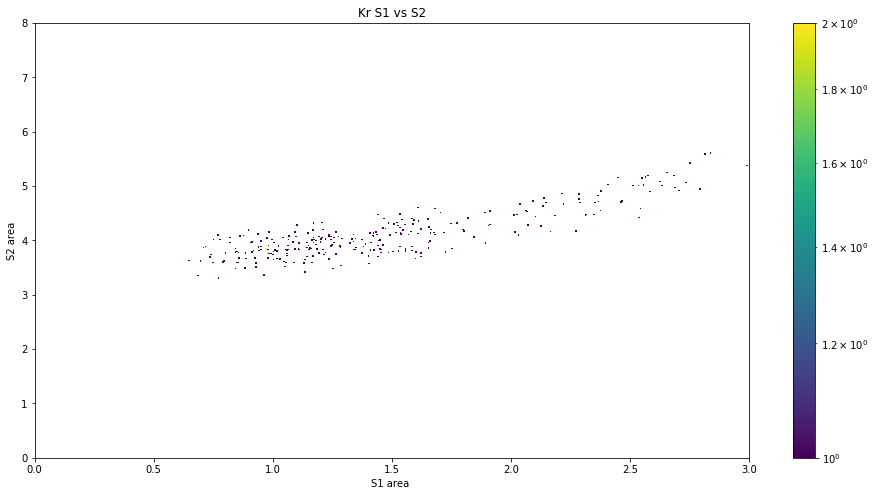

In [11]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(krlogs1c, krlogs2, bins=(1000, 1000),range =  [[0,3], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Kr S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.show()

PILE UP EVENTS

In [56]:
def puscatters(thefile):     
    #get the pulse IDs for s1 and s2 in pile up scatters branch, unfortunately thats all we can do in scatters tree
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    puscatterS1 = scatters.array('pileUp.s1PulseIDs')
    puscatterS2 = scatters.array('pileUp.s2PulseIDs')
    eventID = events.array('eventHeader.eventID')
    nS1 = scatters.array('pileUp.nS1')
    nS2 = scatters.array('pileUp.nS2')
    nPU = scatters.array('pileUp.nPileUpScatters')
    PA = events.array('pulsesTPC.pulseArea_phd')
    xpos = events.array('pulsesTPC.s2Xposition_cm')
    ypos = events.array('pulsesTPC.s2Yposition_cm')
    r2 = np.sqrt(xpos**2 + ypos**2)
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    areaFrac5_us = events.array('pulsesTPC.areaFractionTime5_ns') / 1000
    pulseEdge = startTime_us + areaFrac5_us #beginning time of each pulse
    odstart = events.array('pulsesODHG.pulseStartTime_ns')
    od1nsarea = events.array('pulsesODHG.areaFractionTime1_ns')
    odcoinc = events.array('pulsesODHG.coincidence')


    isPU = nPU > 0 #take only pile up events
    r2 = r2[isPU]
    PA = PA[isPU]
    puscatterS1 = puscatterS1[isPU]
    puscatterS2 = puscatterS2[isPU]
    pulseEdge = pulseEdge[isPU]
    eventID =eventID[isPU]
    rawfile = rawfile[isPU]
    runID = runID[isPU]
    startTime_us = startTime_us[isPU]
    
    S1area = PA[puscatterS1] #find the S1 and S2 areas
    S2area = PA[puscatterS2]
    S1maxID = S1area.argmax() #get index of largest S1
    S2maxID  = S2area.argmax() #get the index of the largest S2
    puscatterS1 = puscatterS1[S1maxID] #get the PIDs that correspond to the maximum areas
    puscatterS2 = puscatterS2[S2maxID]
    S1area = S1area[S1maxID]
    S2area = S2area[S2maxID]

    S1b4S2 = []
    for i,j in zip(puscatterS1,puscatterS2): #make a mask for only the events that have the largest S1 before largest S2
        if i < j:
            S1b4S2.append(True)
        else:
            S1b4S2.append(False)
    S1area = S1area[S1b4S2]
    S2area = S2area[S1b4S2]
    eventID = eventID[S1b4S2]
    rawfile = rawfile[S1b4S2]
    runID = runID[S1b4S2]
    puscatterS2 = puscatterS2[S1b4S2]
    puscatterS1 = puscatterS1[S1b4S2]
    r2 = r2[S1b4S2] 
    startTime_us = startTime_us[S1b4S2]
    pulseEdge = pulseEdge[S1b4S2]
    S1pulseEdge = pulseEdge[puscatterS1]
    S2pulseEdge = pulseEdge[puscatterS2]
    startTime_us = startTime_us[puscatterS1]
    r2 = r2[puscatterS2] #take only r positions that correlate to the largest S2

    drift = np.abs(S1pulseEdge - S2pulseEdge) #find drift time
    upperz = drift < 788.629 
    lowerz = drift > 72.414
    fidz = upperz * lowerz
    flatz = fidz.flatten()
    fidz = np.logical_and(upperz,lowerz) #fidz cut
    r2 = r2[fidz]
    startTime_us = startTime_us[fidz]
    S1area = S1area[fidz]
    S2area = S2area[fidz]
    puscatterS1 = puscatterS1[fidz]
    puscatterS2 = puscatterS2[fidz]
    eventID = eventID[flatz]
    rawfile = rawfile[flatz]
    runID = runID[flatz]
    
    fidr = r2 < 68.8 # fidr cut
    S1area = S1area[fidr]
    S2area = S2area[fidr]
    puscatterS1 = puscatterS1[fidr]
    puscatterS2 = puscatterS2[fidr]
    flatr = fidr.flatten()
    eventID = eventID[flatr]
    rawfile = rawfile[flatr]
    runID = runID[flatr]
    startTime_us = startTime_us[fidr]
    
    Emin = S1area > 100
    Emax = S1area < 500
    EFT = np.logical_and(Emin,Emax)# EFT cut
    S1area = S1area[EFT]
    S2area = S2area[EFT]
    puscatterS1 = puscatterS1[EFT]
    puscatterS2 = puscatterS2[EFT]
    startTime_us = startTime_us[EFT]
    flatEFT = EFT.flatten()
    eventID = eventID[flatEFT]
    rawfile = rawfile[flatEFT]
    runID = runID[flatEFT]
    
    s2min = S2area > 420
    s2max = S2area < 10**8
    S2ID = np.logical_and(s2min,s2min)# EFT cut
    S1area = S1area[S2ID]
    S2area = S2area[S2ID]
    puscatterS1 = puscatterS1[S2ID]
    puscatterS2 = puscatterS2[S2ID]
    startTime_us = startTime_us[S2ID]
    flats2 = S2ID.flatten()
    eventID = eventID[flats2]
    rawfile = rawfile[flats2]
    runID = runID[flats2]
    
    empty = [] 
    for i in S1area: #make sure there are no empty arrays
        if i.size < 1:
            empty.append(False)
        else:
            empty.append(True)
    S1area = S1area[empty]
    S2area = S2area[empty]
    puscatterS1 = puscatterS1[empty]
    puscatterS2 = puscatterS2[empty]
    startTime_us = startTime_us[empty]
    
#    if S1area.size > 0:
#        putext = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/PU/EFTrecon_PU_500phd.txt", "a+")
#        putext2 = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/PU/EFTreconGuide_PU_500phd.txt", "a+")
#        for (i,j,k) in zip(rawfile,runID,eventID):
#            i = i.decode('utf-8')
#            putext.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" "\n" % (i,j,k))
#        putext.close()
#        for (a,b,c,d,e) in zip(rawfile,runID,eventID,startTime_us,puscatterS1):
#            a = a.decode('utf-8')
#            putext2.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" " " "%s" " " "%s" "\n" % (a,b,c,d,e))
#        putext2.close()
#    else: 
#        pass
    
    return puscatterS1, puscatterS2, S1area, S2area, eventID

In [57]:
PUEID = []  #make arrays to load function results into
PUS1PID = []
PUS2PID = []
PUS1area = []
PUS2area = []

In [58]:
nfiles = len(fileloc) # run the function over the list of files
for i, file in enumerate(fileloc):
    if file == "/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-dev-ffn-951eb859/20180303/lz_201803032300_lzap.root":
            continue
    puscatterS1, puscatterS2, S1area, S2area, eventID = puscatters(file) #we don't care about having the mask returned here
    PUEID.append(eventID)
    PUS1PID.append(puscatterS1)
    PUS2PID.append(puscatterS2)
    PUS1area.append(S1area)
    PUS2area.append(S2area)
    update_progress(i, nfiles)

N Files to process = 1440 
Progress: [####################] 99.9%


In [63]:
PUS1PID = list(itertools.chain.from_iterable(PUS1PID))
PUS2PID = list(itertools.chain.from_iterable(PUS2PID))#flatten this list
print(len(PUS2PID))

42


In [30]:
PUS1area = list(itertools.chain.from_iterable(PUS1area)) #flatten these too
PUS2area = list(itertools.chain.from_iterable(PUS2area))
print(len(PUS2area))

0


In [22]:
pulogs1 = np.log10(PUS1area) #take logs of areas
pulogs2 = np.log10(PUS2area)

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


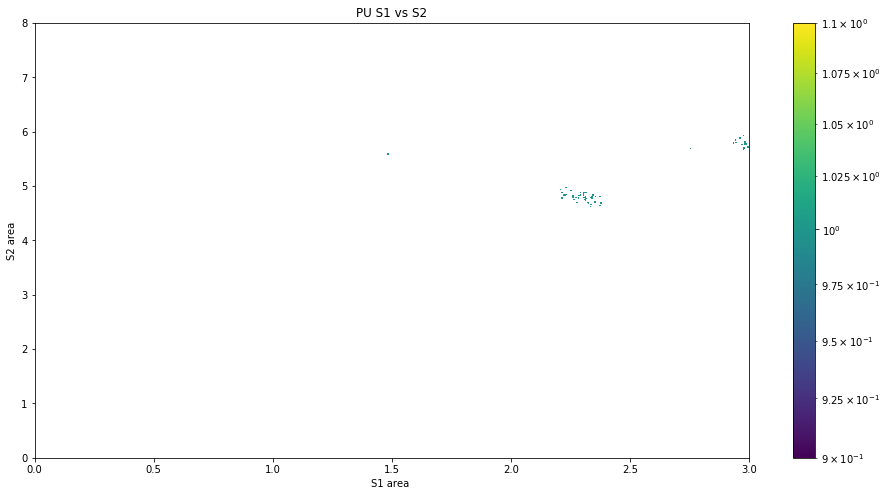

In [23]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(pulogs1, pulogs2, bins=(1000, 1000),range =  [[0,3], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('PU S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.show()

OTHER SCATTERS

In [60]:
def otherscatters(thefile):     
    #others branch is weird, so get all pulse IDs it has and remember to keep them seperate
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventID = events.array('eventHeader.eventID')
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    otherscatterS1 = scatters.array('other.s1PulseIDs')
    otherscatterS2 = scatters.array('other.s2PulseIDs')
    nOther = scatters.array('other.nOtherScatters')
    PA = events.array('pulsesTPC.pulseArea_phd')
    xpos = events.array('pulsesTPC.s2Xposition_cm')
    ypos = events.array('pulsesTPC.s2Yposition_cm')
    r2 = np.sqrt(xpos**2 + ypos**2)
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    areaFrac5_us = events.array('pulsesTPC.areaFractionTime5_ns') / 1000
    pulseEdge = startTime_us + areaFrac5_us #beginning time of each pulse

    isOther = nOther > 0
    S1PID = otherscatterS1[isOther]
    S2PID = otherscatterS2[isOther]
    PA = PA[isOther]
    r2 = r2[isOther]    
    pulseEdge = pulseEdge[isOther]
    eventID =eventID[isOther]
    rawfile = rawfile[isOther]
    runID = runID[isOther]
    startTime_us = startTime_us[isOther]

    OtS1area = PA[S1PID] #find the S1 and S2 areas
    OtS2area = PA[S2PID]
    OtS1area = PA[S1PID] #find the S1 and S2 areas
    OtS2area = PA[S2PID]
    S1maxID = OtS1area.argmax()
    S2maxID = OtS2area.argmax()
    S1PID = S1PID[S1maxID]
    S2PID = S2PID[S2maxID]
    OtS1area = OtS1area[S1maxID]
    OtS2area = OtS2area[S2maxID]


    S1b4S2 = []
    for i,j in zip(S1PID,S2PID): #make a mask for only the events that have the largest S1 before largest S2
        if i < j:
            S1b4S2.append(True)
        else:
            S1b4S2.append(False)
    OtS1area = OtS1area[S1b4S2]
    OtS2area = OtS2area[S1b4S2]
    eventID = eventID[S1b4S2]
    rawfile = rawfile[S1b4S2]
    runID = runID[S1b4S2]
    S1PID = S1PID[S1b4S2]
    S2PID = S2PID[S1b4S2]
    r2 = r2[S1b4S2] 
    pulseEdge = pulseEdge[S1b4S2]
    startTime_us = startTime_us[S1b4S2]
    S1pulseEdge = pulseEdge[S1PID]
    S2pulseEdge = pulseEdge[S2PID]
    startTime_us = startTime_us[S1PID]
    r2 = r2[S2PID] #take only r positions that correlate to the largest S2

    drift = np.abs(S1pulseEdge - S2pulseEdge) #find drift time
    upperz = drift < 788.629 
    lowerz = drift > 72.414
    fidz = upperz * lowerz
    flatz = fidz.flatten()
    fidz = np.logical_and(upperz,lowerz) #fidz cut
    r2 = r2[fidz]
    startTime_us = startTime_us[fidz]
    OtS1area = OtS1area[fidz]
    OtS2area = OtS2area[fidz]
    S1PID = S1PID[fidz]
    S2PID = S2PID[fidz]
    eventID = eventID[flatz]
    rawfile = rawfile[flatz]
    runID = runID[flatz]

    fidr = r2 < 68.8 # fidr cut
    OtS1area = OtS1area[fidr]
    OtS2area = OtS2area[fidr]
    S1PID = S1PID[fidr]
    S2PID = S2PID[fidr]
    flatr = fidr.flatten()
    eventID = eventID[flatr]
    rawfile = rawfile[flatr]
    runID = runID[flatr]
    startTime_us = startTime_us[fidr]

    Emin = OtS1area > 100
    Emax = OtS1area < 500
    EFT = np.logical_and(Emin,Emax) # EFT cut
    OtS1area = OtS1area[EFT]
    OtS2area = OtS2area[EFT]
    S1PID = S1PID[EFT]
    S2PID = S2PID[EFT]
    flatEFT = EFT.flatten()
    eventID = eventID[flatEFT]
    rawfile = rawfile[flatEFT]
    runID = runID[flatEFT]
    startTime_us = startTime_us[EFT]

    s2min = OtS2area > 420
    s2max = OtS2area < 10**8
    S2ID = np.logical_and(s2min,s2max)# EFT cut
    OtS1area = OtS1area[S2ID]
    OtS2area = OtS2area[S2ID]
    S1PID = S1PID[S2ID]
    S2PID = S2PID[S2ID]
    startTime_us = startTime_us[S2ID]
    flats2 = S2ID.flatten()
    eventID = eventID[flats2]
    rawfile = rawfile[flats2]
    runID = runID[flats2]
    
    empty = [] 
    for i in OtS1area: #make sure there are no empty arrays
        if i.size < 1:
            empty.append(False)
        else:
            empty.append(True)
    OtS1area = OtS1area[empty]
    OtS2area = OtS2area[empty]
    S1PID = S1PID[empty]
    S2PID = S2PID[empty]
    startTime_us = startTime_us[empty]
#    if OtS1area.size > 0:
#        Otext = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/Other/EFTrecon_Other_500phd.txt", "a+")
#        Otext2 = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Rn_data/Other/EFTreconGuide_Other_500phd.txt", "a+")
#        for (i,j,k) in zip(rawfile,runID,eventID):
#            i = i.decode('utf-8')
#            Otext.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" "\n" % (i,j,k))
#        Otext.close()
#        for (a,b,c,d,e) in zip(rawfile,runID,eventID,startTime_us,S1PID):
#            a = a.decode('utf-8')
#            Otext2.write("/global/cfs/cdirs/lz/data/MDC3/calibration/BACCARAT-4.10.3_DER-8.5.13/20180312/%s" " " "%s" " " "%s" " " "%s" " " "%s" "\n" % (a,b,c,d,e))
#        Otext2.close()
#    else: 
#        pass
       
    return S1PID, S2PID, OtS1area, OtS2area, eventID

Otext = open("/global/project/projectdirs/lz/users/mwilliams/EFTrecon/Other/EFTrecon_Other_1_2phd.txt", "a+")
Otext.seek(0)
count = len(Otext.readlines())
print(count)
if count <= 13:
    for i in range(0,10):
        Otext.write("blah""\n")
Otext.close()

In [61]:
OEID = []  #make arrays to load function results into
OS1PID = []
OS2PID = []
OS1area = []
OS2area = []

In [62]:
nfiles = len(fileloc) # run the function over the list of files
for i, file in enumerate(fileloc):
    if file == "/global/cfs/cdirs/lz/data/MDC3/commissioning/LZAP-dev-ffn-951eb859/20180303/lz_201803032300_lzap.root":
        continue
    S1PID, S2PID, OtS1area, OtS2area, eventID = otherscatters(file) #we don't care about having the mask returned here
    OEID.append(eventID)
    OS1PID.append(S1PID)
    OS2PID.append(S2PID)
    OS1area.append(OtS1area)
    OS2area.append(OtS2area)
    update_progress(i, nfiles)

N Files to process = 1440 
Progress: [####################] 99.9%


In [64]:
OS1PID = list(itertools.chain.from_iterable(OS1PID))
OS2PID = list(itertools.chain.from_iterable(OS2PID))#flatten this list
print(len(OS2PID))

12123


In [35]:
OS1area = list(itertools.chain.from_iterable(OS1area)) #flatten these too
OS2area = list(itertools.chain.from_iterable(OS2area))
print(len(OS2area))

1


In [38]:
ologs1 = np.log10(OS1area) #take logs of areas
ologs2 = np.log10(OS2area)

ValueError: too many values to unpack (expected 2)

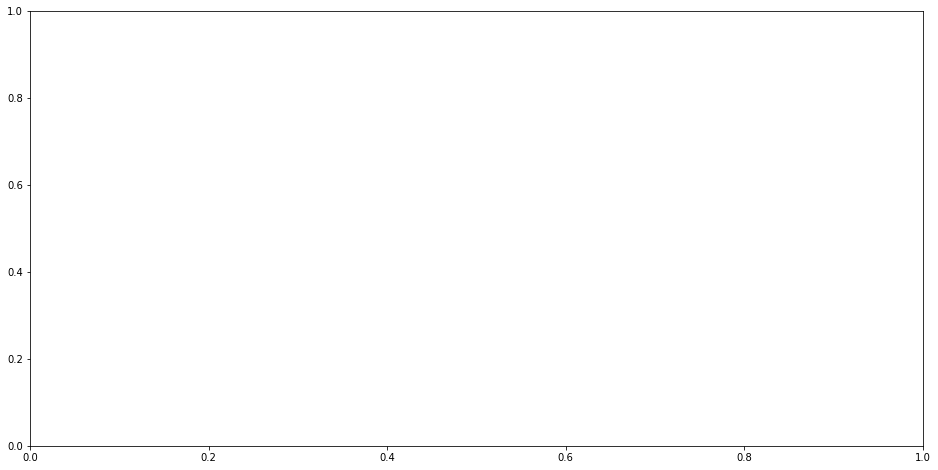

In [39]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(ologs1, ologs2, bins=(1000, 1000),range =  [[0,3], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Other S1 vs S2')
ax.set_xlabel('S1 area ')
ax.set_ylabel('S2 area')
plt.show()

In [36]:
totalS1 = np.concatenate([ssS1area,msS1area,krS1aarea,PUS1area,OS1area])
print(len(totalS1))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 4 has 2 dimension(s)

PULSE RATIO PLOTS

In [ ]:
def pulsestats(thefile, scatter): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    eventsPID = events.array('pulsesTPC.pulseID')
    PA = events.array('pulsesTPC.pulseArea_phd')
    S1prob = events.array('pulsesTPC.s1Probability')
    S2prob = events.array('pulsesTPC.s2Probability')
    PH = events.array('pulsesTPC.peakAmp')
    a = events.array('pulsesTPC.areaFractionTime95_ns')
    b = events.array('pulsesTPC.areaFractionTime5_ns')
    PW = a - b
    
    if scatter == "ss":
        mask = singlescatter(thefile)[0]
    if scatter == "ms":
        mask = multiscatter(thefile)[0]
    if scatter == "kr":
        mask = krscatter(thefile)[0]

    S1prob = S1prob[mask]
    S2prob = S2prob[mask] 
    PA = PA[mask] 
    PW = PW[mask]
    PH = PH[mask]    
    
    isS1 = S1prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS1 = PA[isS1] # grab pulse areas for S1s
    PWS1 = PW[isS1]
    PHS1 = PH[isS1]


    morethan1_S1 = PAS1.count() > 1 #make a mask that makes sure there are multple S1s in an event
    PA_MultiS1 = PAS1[morethan1_S1] #get the relevant areas, width, and heights
    PW_MultiS1 = PWS1[morethan1_S1]
    PH_MultiS1 = PHS1[morethan1_S1]
    PA_MultiS1 # Only have events with more than 1 s1 now

    PAmaxS1 = PA_MultiS1.max()  #find the max area in each event
    S1small = PA_MultiS1.argsort() == 1 #mask to find the 2nd largest S1 in an event
    PAsmallS1 = PA_MultiS1[S1small] #2nd largest area
    PHsmallS1 = PH_MultiS1[S1small] #2nd largest height
    PWsmallS1 = PW_MultiS1[S1small] #2nd largest width

    S1ratio = np.log10(PAsmallS1 / PAmaxS1) #calculate desired ratios to plot
    S1_h2w_ratio = np.log10(PHsmallS1 / PWsmallS1)
    
    #do exact same for S2s   
    isS2 = S2prob > 0 #assign a boolean true for a value with a S1 to make a mask for S1s
    PAS2 = PA[isS2] # grab pulse areas for S1s
    PWS2 = PW[isS2]
    PHS2 = PH[isS2]


    morethan1_S2 = PAS2.count() > 1
    PA_MultiS2 = PAS2[morethan1_S2]
    PW_MultiS2 = PWS2[morethan1_S2]
    PH_MultiS2 = PHS2[morethan1_S2]
    PA_MultiS2 # Only have events with more than 1 s1 now

    PAmaxS2 = PA_MultiS2.max()
    S2small = PA_MultiS2.argsort() == 1
    PAsmallS2 = PA_MultiS2[S2small]
    PHsmallS2 = PH_MultiS2[S2small]
    PWsmallS2 = PW_MultiS2[S2small]

    S2ratio = np.log10(PAsmallS2 / PAmaxS2)
    S2_h2w_ratio = np.log10(PHsmallS2 / PWsmallS2)
    
    print('processed file', thefile)
    return S1ratio , S1_h2w_ratio , S2ratio , S2_h2w_ratio

In [ ]:
S1xaxis = []
S1yaxis = []
S2xaxis = []
S2yaxis = []

In [ ]:
nfiles = len(fileloc)
for i, file in enumerate(fileloc):
    S1x,S1y,S2x,S2y = pulsestats(file,"ss")
    S1xaxis.append(S1x)
    S1yaxis.append(S1y)
    S2xaxis.append(S2x)
    S2yaxis.append(S2y)
    update_progress(i, nfiles)

In [ ]:
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
S1xaxis = list(itertools.chain.from_iterable(S1xaxis))
S1yaxis = list(itertools.chain.from_iterable(S1yaxis))
print(len(S1xaxis))

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S1xaxis, S1yaxis, bins=(1000, 1000),range =  [[-5, 0], [-5, 0]], cmin=1,norm=matplotlib.colors.LogNorm())
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('2nd S1 Area over Largest S1 area ')
ax.set_ylabel('Height/Width of 2nd largest S1')
plt.show()

In [ ]:
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
S2xaxis = list(itertools.chain.from_iterable(S2xaxis))
S2yaxis = list(itertools.chain.from_iterable(S2yaxis))
print(len(S2xaxis))

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(S2xaxis, S2yaxis, bins=(1000, 1000),range =  [[-5, 0], [-6, 0]], cmin=1,norm=matplotlib.colors.LogNorm())
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('2nd S2 Area over Largest S2 area ')
ax.set_ylabel('Height/Width of 2nd largest S2')
plt.show()